# Global Imports


In [8]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

### import data

In [10]:
train = pd.read_csv('Projects_data/train_2016_v2.csv', parse_dates=["transactiondate"])
properties = pd.read_csv('Projects_data/properties_2016.csv')

### shape of the Dataset

In [11]:
print('Shape of train', train.shape)
print('Shape of properties', properties.shape)

Shape of train (90275, 3)
Shape of properties (2985217, 58)


### Merge Train and Properties 

In [12]:
merged = pd.merge(train, properties, on= 'parcelid', how = 'left')

In [13]:
merged.head(5).transpose()

,0,1,2,3,4
parcelid,11016594,14366692,12098116,12643413,14432541
logerror,0.0276,-0.1684,-0.004,0.0218,-0.005
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-02 00:00:00
airconditioningtypeid,1,NaN,1,1,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,2,3.5,3,2,2.5
bedroomcnt,3,4,2,2,4
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4,4,NaN


### Datatypes Visulization

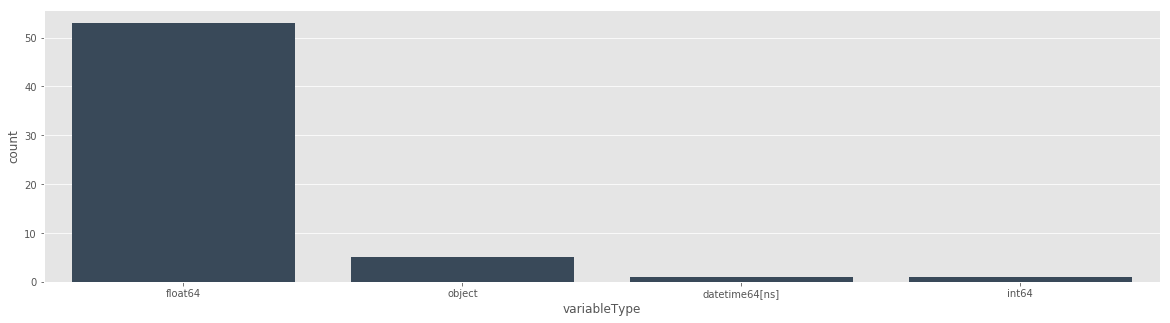

In [14]:
data_type_df = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType", 0:"count"})
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=data_type_df, x='variableType', y='count', ax=ax, color = '#34495e')
#ax.set(xlabel = 'Variable Type', ylabel='Count', title='Variables Count Across Datatype')

### Missing Value Analysis

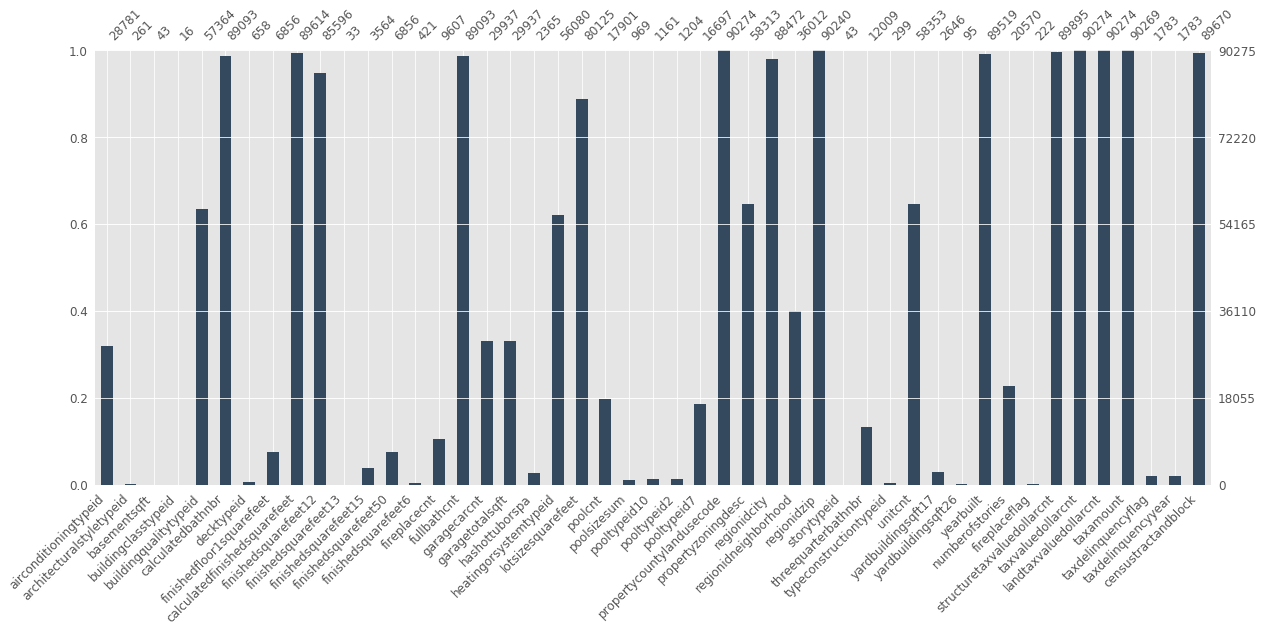

In [15]:
missing_value_columns = merged.columns[merged.isnull().any()].tolist()
msno.bar(merged[missing_value_columns], figsize = (20,8), color='#34495e', fontsize= 12, labels= True)

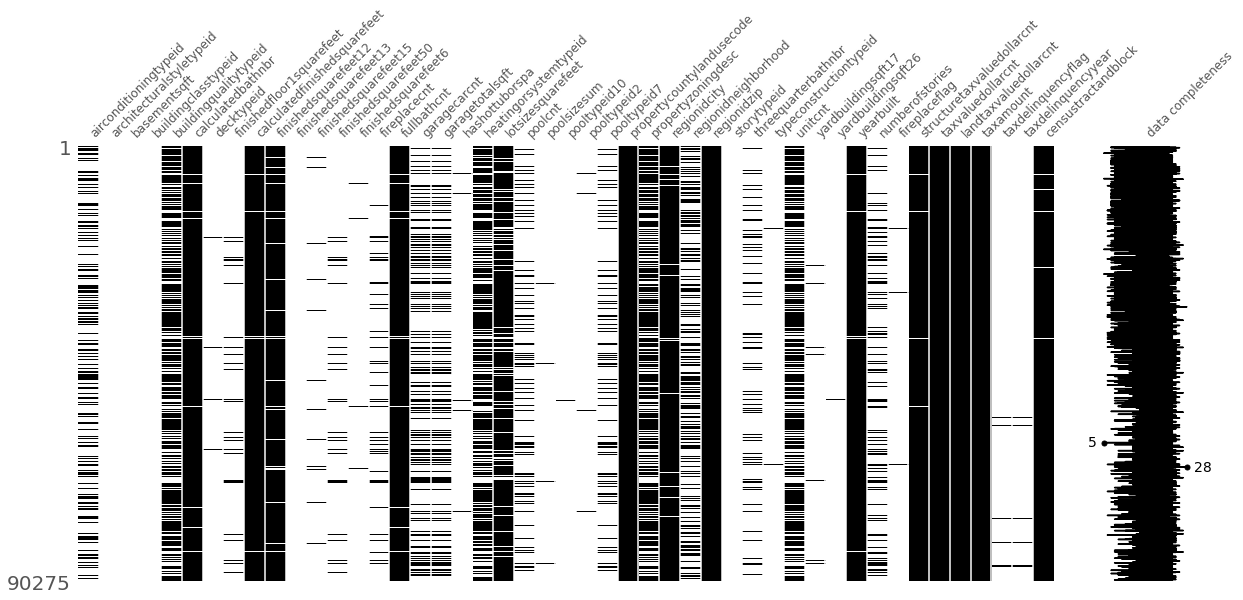

In [16]:
msno.matrix(merged[missing_value_columns], width_ratios=(10,1), \
            figsize=(20,8), color = (0,0,0), fontsize= 12, sparkline=True, labels=True)

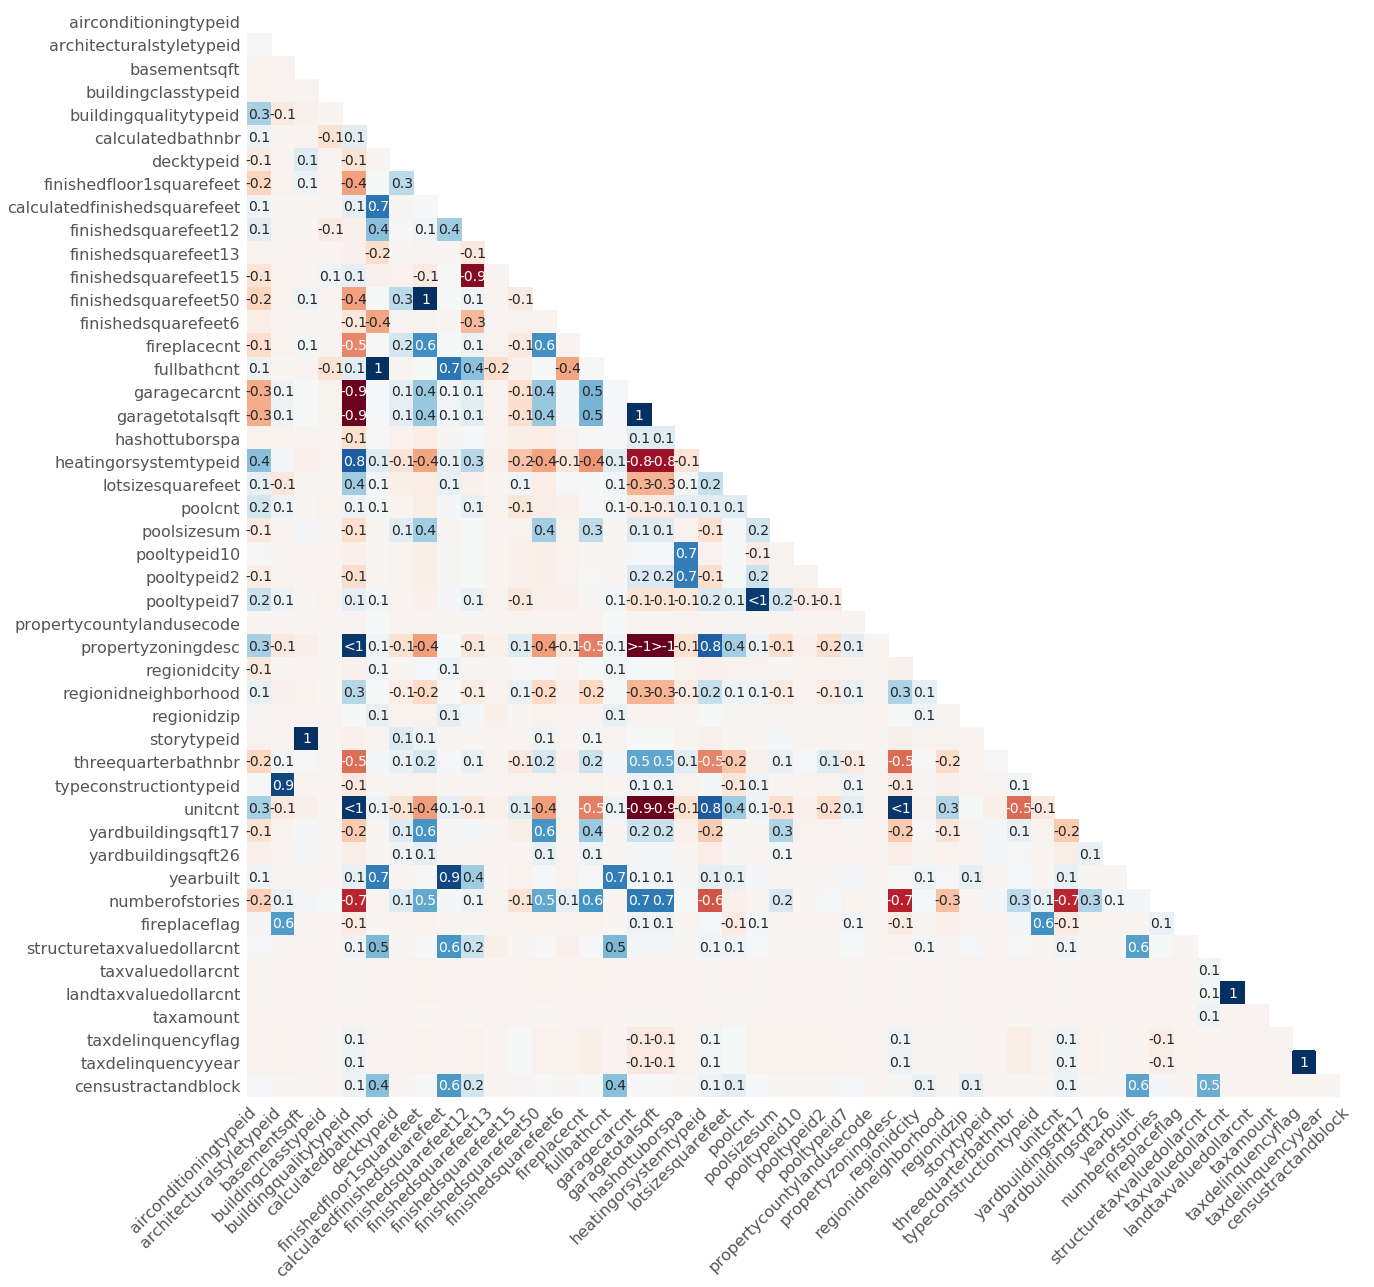

In [17]:
msno.heatmap(merged[missing_value_columns], figsize=(20,20))

### Top Features Selection

In [18]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [19]:
mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()                         
        lbl.fit(list(mergedFilterd[f].values))                               #fill label encoder  
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))      #fill with 0

In [20]:
train_y = mergedFilterd['logerror'].values
train_X = mergedFilterd.drop(['parcelid', 'transactiondate', 'logerror'], axis=1)

In [21]:
xgb_params = {
    'eta':0.05,
    'max_depth':8,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'reg:linear',
    'evalmetric': 'rmse',
    'silent':1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names = train_X.columns.values) #load data 
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

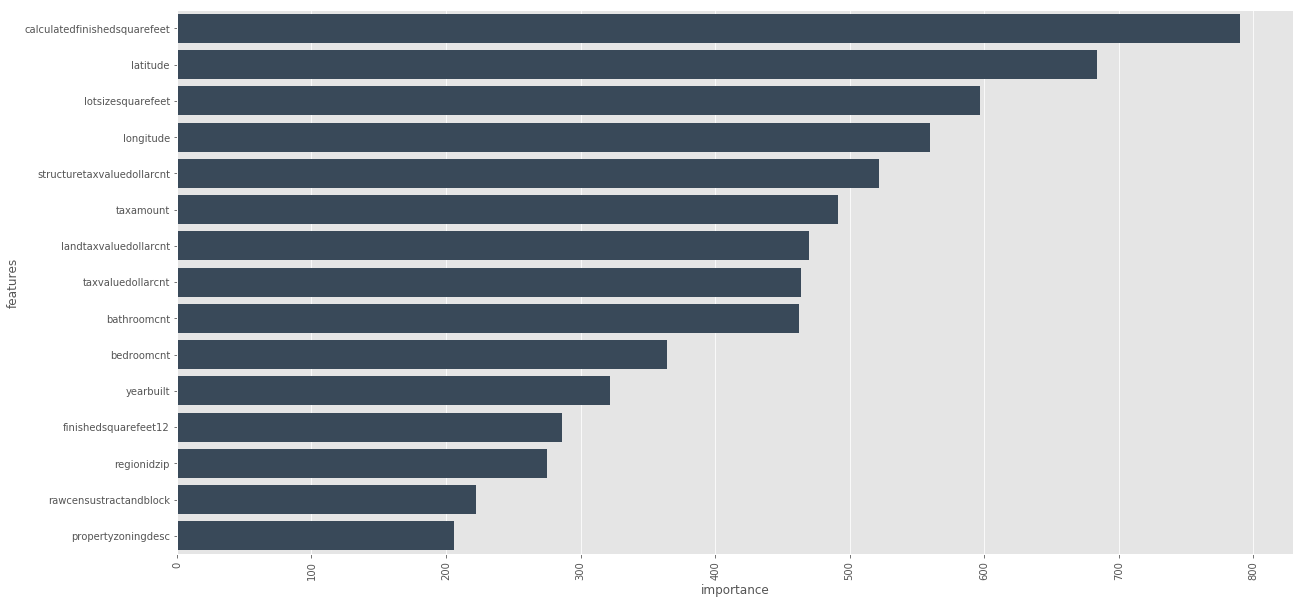

In [22]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'], ascending=False, inplace=True)
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(15), x='importance', y='features', ax=ax, orient='h', color='#34495e')

In [23]:
features.head(5)

,features,importance
7,calculatedfinishedsquarefeet,790
11,latitude,684
24,lotsizesquarefeet,597
2,longitude,560
12,structuretaxvaluedollarcnt,522


### Correlation Analysis

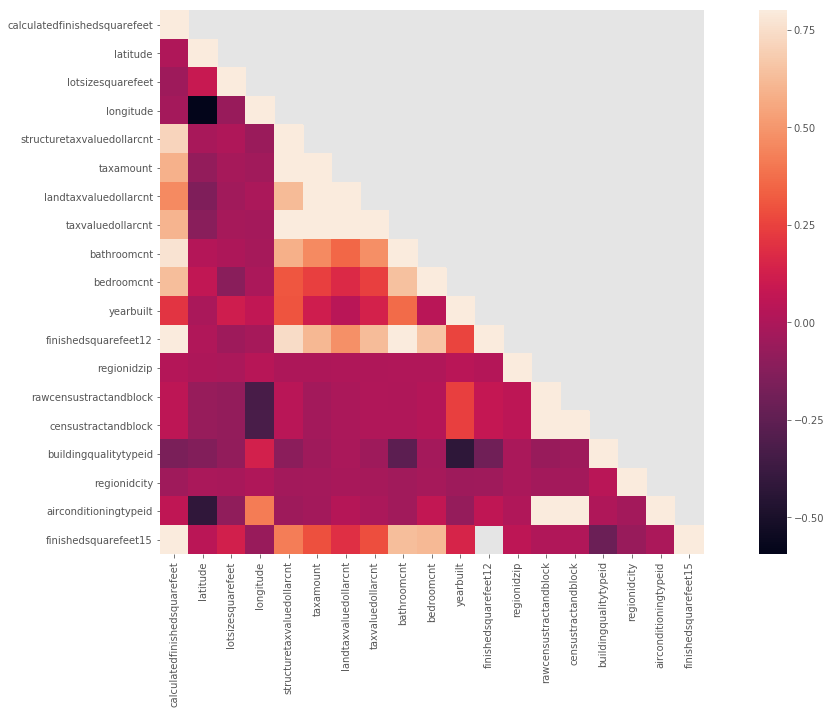

In [36]:
topFeatures = features['features'].tolist()[:20]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False 
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask, vmax=.8, square=True) 

In [25]:
mask

array([[ 0.00000000e+00,  9.32097026e-03, -4.87698257e-02,
        -2.23685709e-02,  7.16488519e-01,  5.89022465e-01,
         4.58550189e-01,  6.00018181e-01,  7.72552605e-01,
         6.32034654e-01,  2.11640900e-01,  1.00000000e+00,
         2.28895066e-02,  5.86767962e-02,  5.87925683e-02,
        -1.58691131e-01, -4.18338597e-02,  5.96669511e-02,
         1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.19478307e-02,
        -5.94096577e-01, -1.35478096e-02, -7.84108737e-02,
        -1.47394117e-01, -1.12393595e-01,  2.27110129e-02,
         6.63310558e-02, -7.47465984e-03,  1.08039925e-02,
         2.04810810e-04, -7.01182362e-02, -7.04581751e-02,
        -1.34658567e-01, -8.70537169e-03, -4.17596086e-01,
         4.39168682e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -6.57071814e-02,  8.65499675e-03, -2.20377098e-02,
        -3.40302275e-02, -2.13467292e-02, -1.96835157e-04,
        -1.13983710e-01,  1.18078170e-01, -4.67064051e-02,
    

In [26]:
corrMatt

,calculatedfinishedsquarefeet,latitude,lotsizesquarefeet,longitude,structuretaxvaluedollarcnt,taxamount,landtaxvaluedollarcnt,taxvaluedollarcnt,bathroomcnt,bedroomcnt,yearbuilt,finishedsquarefeet12,regionidzip,rawcensustractandblock,censustractandblock,buildingqualitytypeid,regionidcity,airconditioningtypeid,finishedsquarefeet15
calculatedfinishedsquarefeet,1.000000,0.009321,-0.048770,-0.022369,0.716489,0.589022,0.458550,0.600018,0.772553,0.632035,0.211641,1.000000,0.022890,0.058677,0.058793,-0.158691,-0.041834,0.059667,1.000000
latitude,0.009321,1.000000,0.091948,-0.594097,-0.013548,-0.078411,-0.147394,-0.112394,0.022711,0.066331,-0.007475,0.010804,0.000205,-0.070118,-0.070458,-0.134659,-0.008705,-0.417596,0.043917
lotsizesquarefeet,-0.048770,0.091948,1.000000,-0.065707,0.008655,-0.022038,-0.034030,-0.021347,-0.000197,-0.113984,0.118078,-0.046706,-0.003748,-0.079100,-0.078503,-0.086515,-0.011855,-0.090773,0.125495
longitude,-0.022369,-0.594097,-0.065707,1.000000,-0.059807,-0.035154,-0.004087,-0.024682,-0.018347,-0.004879,0.068977,-0.021118,0.036801,-0.327582,-0.325381,0.135084,0.009960,0.415025,-0.061608
structuretaxvaluedollarcnt,0.716489,-0.013548,0.008655,-0.059807,1.000000,0.795014,0.623292,0.826052,0.586641,0.305405,0.299696,0.744048,0.002106,0.038109,0.038507,-0.105382,-0.030709,-0.047324,0.423238
taxamount,0.589022,-0.078411,-0.022038,-0.035154,0.795014,1.000000,0.902713,0.949376,0.461900,0.239118,0.115647,0.612496,0.001434,-0.031046,-0.030396,-0.042005,-0.026625,-0.028251,0.291227
landtaxvaluedollarcnt,0.458550,-0.147394,-0.034030,-0.004087,0.623292,0.902713,1.000000,0.955336,0.353806,0.173205,0.039493,0.480463,0.006802,-0.002037,-0.001801,-0.011348,-0.013734,0.027169,0.194818
taxvaluedollarcnt,0.600018,-0.112394,-0.021347,-0.024682,0.826052,0.949376,0.955336,1.000000,0.476363,0.241329,0.140940,0.626052,0.005689,0.012442,0.013039,-0.046708,-0.021307,-0.001102,0.287586
bathroomcnt,0.772553,0.022711,-0.000197,-0.018347,0.586641,0.461900,0.353806,0.476363,1.000000,0.646120,0.368061,0.799372,0.012265,0.009713,0.013078,-0.259748,-0.037242,-0.037479,0.633631
bedroomcnt,0.632035,0.066331,-0.113984,-0.004879,0.305405,0.239118,0.173205,0.241329,0.646120,1.000000,0.040871,0.657599,0.014874,0.024190,0.028170,-0.025736,-0.022166,0.075327,0.615172


### Multicollinearity Analysis

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [28]:
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {}
    for ix, variable in enumerate(list(X.columns)):
        vif[variable] = variance_inflation_factor(exog=X.values, exog_idx=ix)
    return vif

In [29]:
numericalCol = []
for f in merged.columns:
    if merged[f].dtype!='object' and f not in ['parcelid', 'transactiondate', 'logerror']:
        numericalCol.append(f)
mergedFilterd = merged[numericalCol].fillna(-999) #？why -999
vifDict = calculate_vif_(mergedFilterd)

In [30]:
vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'], ascending=False, inplace=True)
vifDf

,variables,vifScore
11,finishedsquarefeet12,2.817303e+11
10,calculatedfinishedsquarefeet,6.320323e+09
25,poolcnt,6.110627e+09
29,pooltypeid7,4.518148e+09
13,finishedsquarefeet15,2.163587e+09
15,finishedsquarefeet6,1.241104e+09
46,taxvaluedollarcnt,1.287209e+08
28,pooltypeid2,8.722728e+07
12,finishedsquarefeet13,8.488108e+07
48,landtaxvaluedollarcnt,6.705584e+07


In [31]:
validVariables = vifDf[vifDf['vifScore']<=5]
variablesWithMC = vifDf[vifDf['vifScore']>5] #vif 不都是0-1吗？

[Text(0,0.5,'Features'),
 Text(0.5,0,'VIF Scores'),
 Text(0.5,1,'Variables Which Exhibit Multicollinearity')]

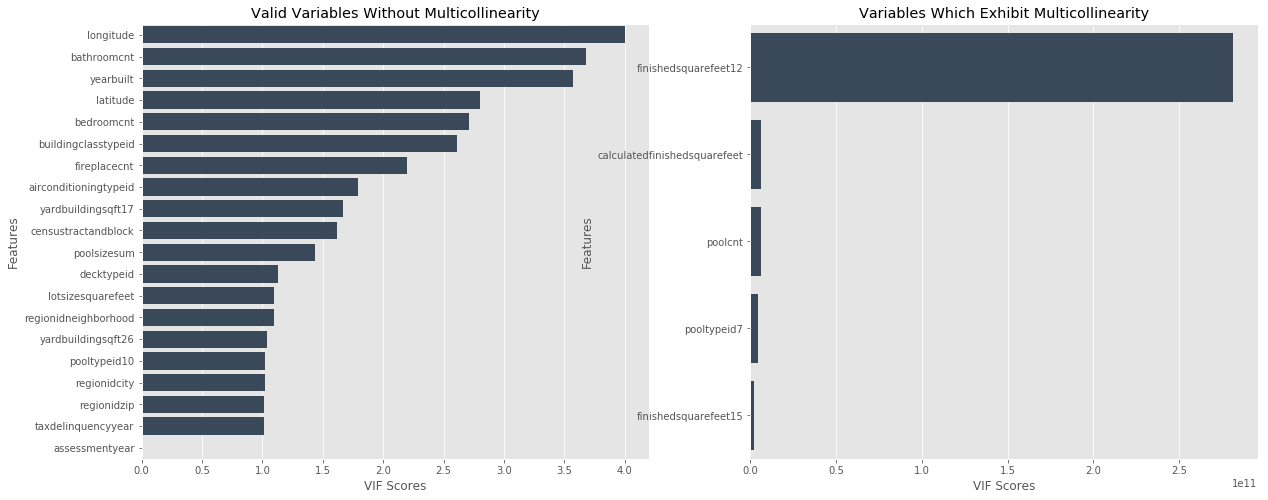

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sn.barplot(data=validVariables, x='vifScore', y='variables', ax=ax1, orient='h', color='#34495e')
sn.barplot(data=variablesWithMC.head(5), x='vifScore', y='variables', ax=ax2, orient='h', color='#34495e')
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity") #?

### Univariate Analysis
#### Dependent variable logerror follows nice normal distribution

In [33]:
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1) #?

In [34]:
ulimit

0.4638819999999963

In [35]:
llimit

-0.3425

In [41]:
merged['logerror'].ix[merged['logerror']>ulimit] = ulimit
merged['logerror'].ix[merged['logerror']<llimit] = llimit

[Text(0,0.5,'VIF Score'),
 Text(0.5,0,'logerror'),
 Text(0.5,1,'Distribution Of Dependent Variable')]

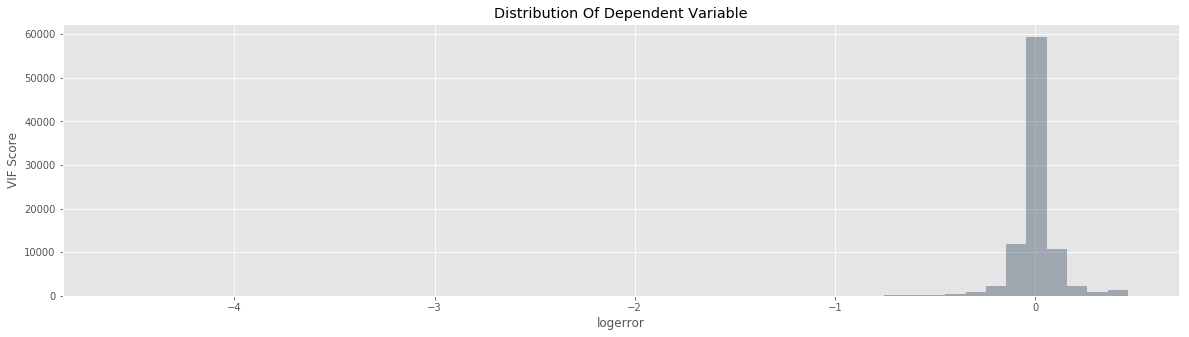

In [55]:
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.distplot(merged.logerror.values, bins=50,kde=False,color="#34495e",ax=ax)
ax.set(xlabel='logerror', ylabel='VIF Score',title="Distribution Of Dependent Variable") #?

0.4638819999999963

### Bivariate Analysis

In [58]:
train.head(5)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [63]:
train['year'] = train.transactiondate.map(lambda x: str(x).split('-')[0])
train['month'] = train.transactiondate.map(lambda x: str(x).split('-')[1])
train['day'] = train.transactiondate.map(lambda x: str(x).split('-')[2].split()[0])


In [65]:
train.head(5)

,parcelid,logerror,transactiondate,year,month,day
0,11016594,0.0276,2016-01-01,2016,01,01
1,14366692,-0.1684,2016-01-01,2016,01,01
2,12098116,-0.0040,2016-01-01,2016,01,01
3,12643413,0.0218,2016-01-02,2016,01,02
4,14432541,-0.0050,2016-01-02,2016,01,02


In [77]:
traingroupedMonth = train.groupby(['month'])['logerror'].mean().to_frame().reset_index()
traingroupedDay = train.groupby(["day"])["logerror"].mean().to_frame().reset_index()

#### Month Analysis

In [78]:
traingroupedMonth

,month,logerror
0,01,0.015870
1,02,0.016082
2,03,0.009867
3,04,0.006605
4,05,0.006926
5,06,0.007172
6,07,0.011687
7,08,0.011573
8,09,0.016255
9,10,0.016342


[Text(0,0.5,'No Of Occurences'),
 Text(0.5,0,'Month Of The Year'),
 Text(0.5,1,'No Of Occurunces Across Month In 2016'),
 None]

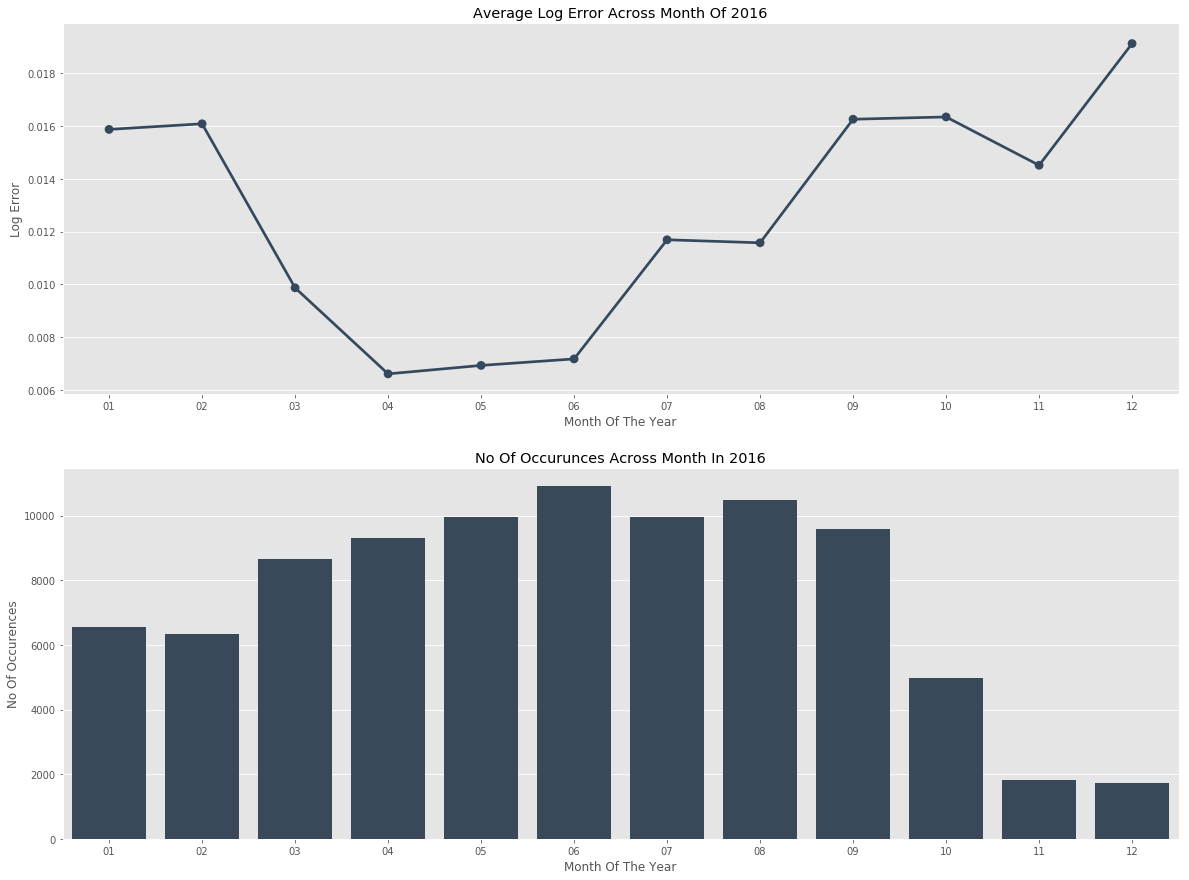

In [90]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)

sn.pointplot(x=traingroupedMonth['month'], y=traingroupedMonth['logerror'], data=traingroupedMonth, join=True, ax=ax1, color='#34495e')
ax1.set(xlabel='Month Of The Year', ylabel='Log Error',title="Average Log Error Across Month Of 2016",label='big')

sn.countplot(x=train['month'], data=train, ax=ax2, color='#34495e')
ax2.set(xlabel='Month Of The Year', ylabel='No Of Occurences',title="No Of Occurunces Across Month In 2016",label='big')

#### Log Error Across Days Analysis

[Text(0,0.5,'No Of Occurences'),
 Text(0.5,0,'Day Of The Month'),
 Text(0.5,1,'No Of Occurences Across Days Of The Month In 2016'),
 None]

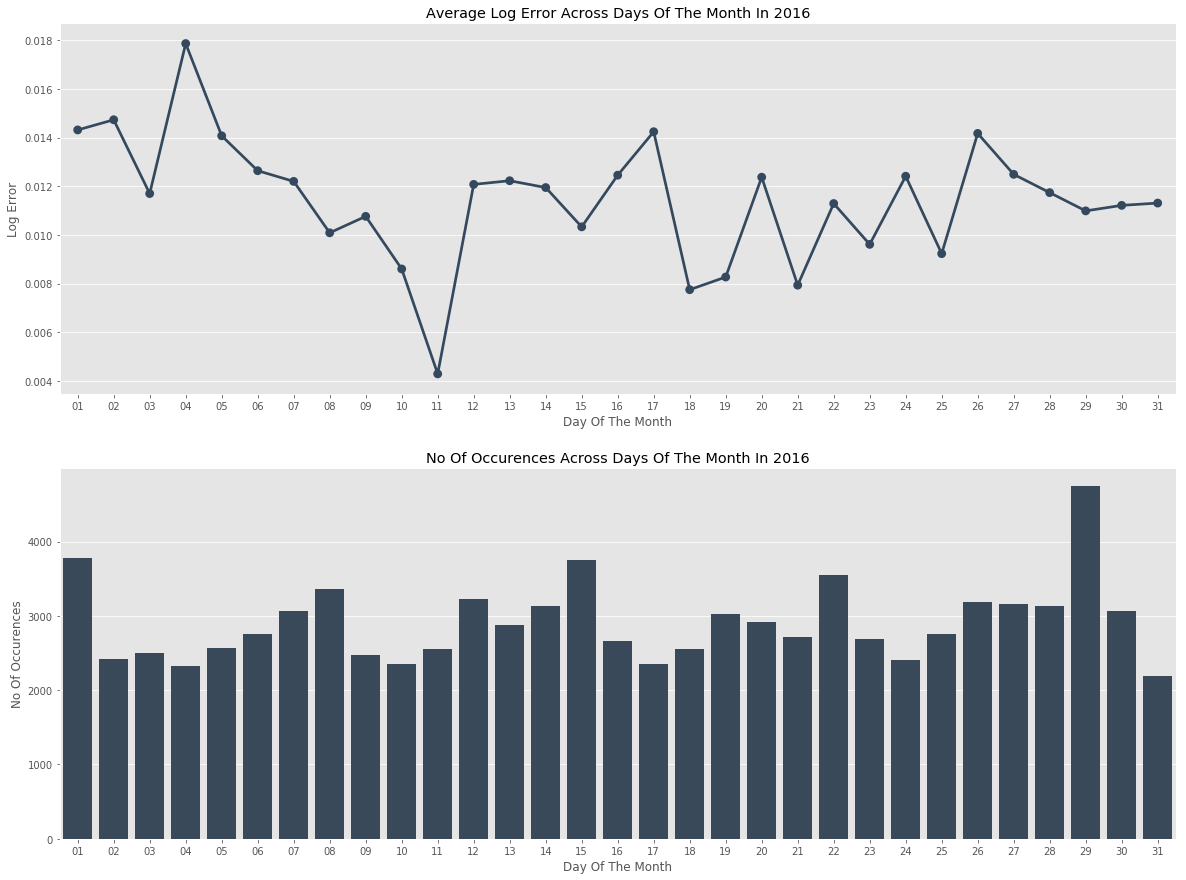

In [94]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)

sn.pointplot(x=traingroupedDay["day"], y=traingroupedDay["logerror"], data=traingroupedDay, join=True,ax=ax1,color="#34495e")
ax1.set(xlabel='Day Of The Month', ylabel='Log Error',title="Average Log Error Across Days Of The Month In 2016",label='big')

sn.countplot(x=train["day"], data=train,ax=ax2,color="#34495e")
ax2.set(xlabel='Day Of The Month', ylabel='No Of Occurences',title="No Of Occurences Across Days Of The Month In 2016",label='big')

### No Of Storey Over The Years


#### It is quite interesting to notice people started building more of 2 or 3 storey buildings After 1950

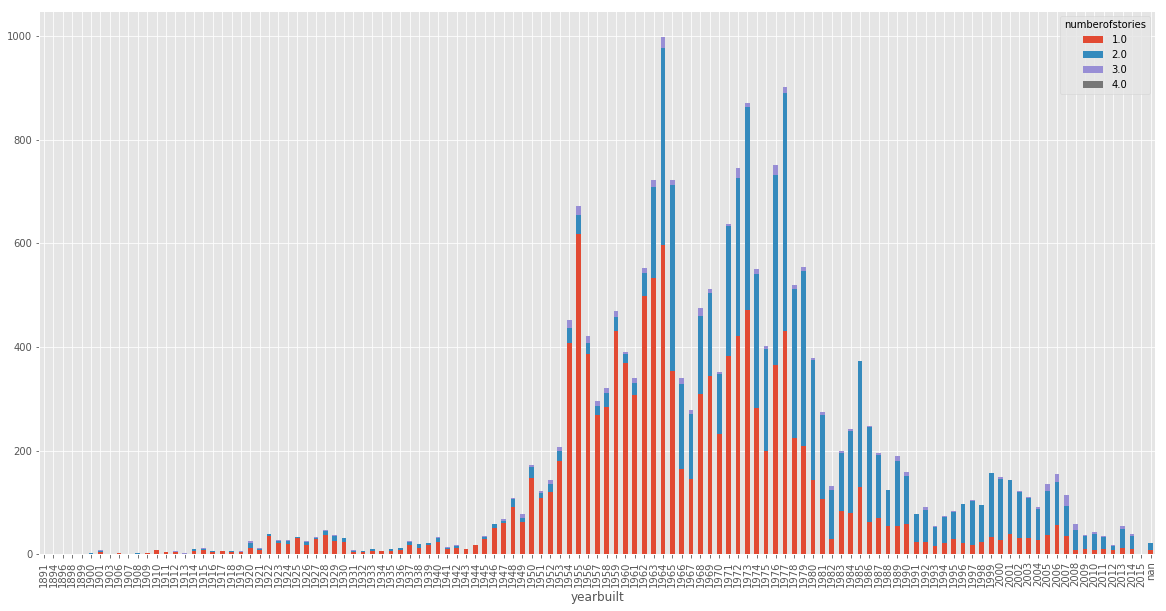

In [103]:
fig,ax1= plt.subplots()
fig.set_size_inches(20,10)
merged["yearbuilt"] = merged["yearbuilt"].map(lambda x:str(x).split(".")[0])
yearMerged = merged.groupby(['yearbuilt', 'numberofstories'])["parcelid"].count().unstack('numberofstories').fillna(0)
yearMerged.plot(kind='bar', stacked=True,ax=ax1)

In [104]:
cols = ["bathroomcnt","bedroomcnt","roomcnt","numberofstories","logerror","calculatedfinishedsquarefeet"]
mergedFiltered = merged[cols].dropna() #why did he choose this features?
for col in cols:
    ulimit = np.percentile(mergedFiltered[col].values, 99.5)
    llimit = np.percentile(mergedFiltered[col].values, 0.5)
    mergedFiltered[col].ix[mergedFiltered[col]>ulimit] = ulimit
    mergedFiltered[col].ix[mergedFiltered[col]<llimit] = llimit

In [106]:
mergedFiltered.head(10) 

,bathroomcnt,bedroomcnt,roomcnt,numberofstories,logerror,calculatedfinishedsquarefeet
4,2.5,4.0,8.0,2.0,-0.0050,2283.0
7,2.5,3.0,6.0,2.0,0.1638,1763.0
9,2.0,2.0,5.0,1.0,0.0843,1260.0
14,2.0,2.0,6.0,1.0,-0.0450,1367.0
15,2.0,3.0,5.0,1.0,0.0020,1302.0
16,2.5,3.0,6.0,2.0,0.0440,1558.0
18,2.0,3.0,6.0,1.0,-0.0020,1321.0
21,2.0,2.0,5.0,1.0,0.0218,1476.0
22,2.0,4.0,7.0,1.0,0.0149,1430.0
27,2.5,2.0,5.0,2.0,0.0080,1858.0


### Calculated Finished Square Feet Vs Log Error

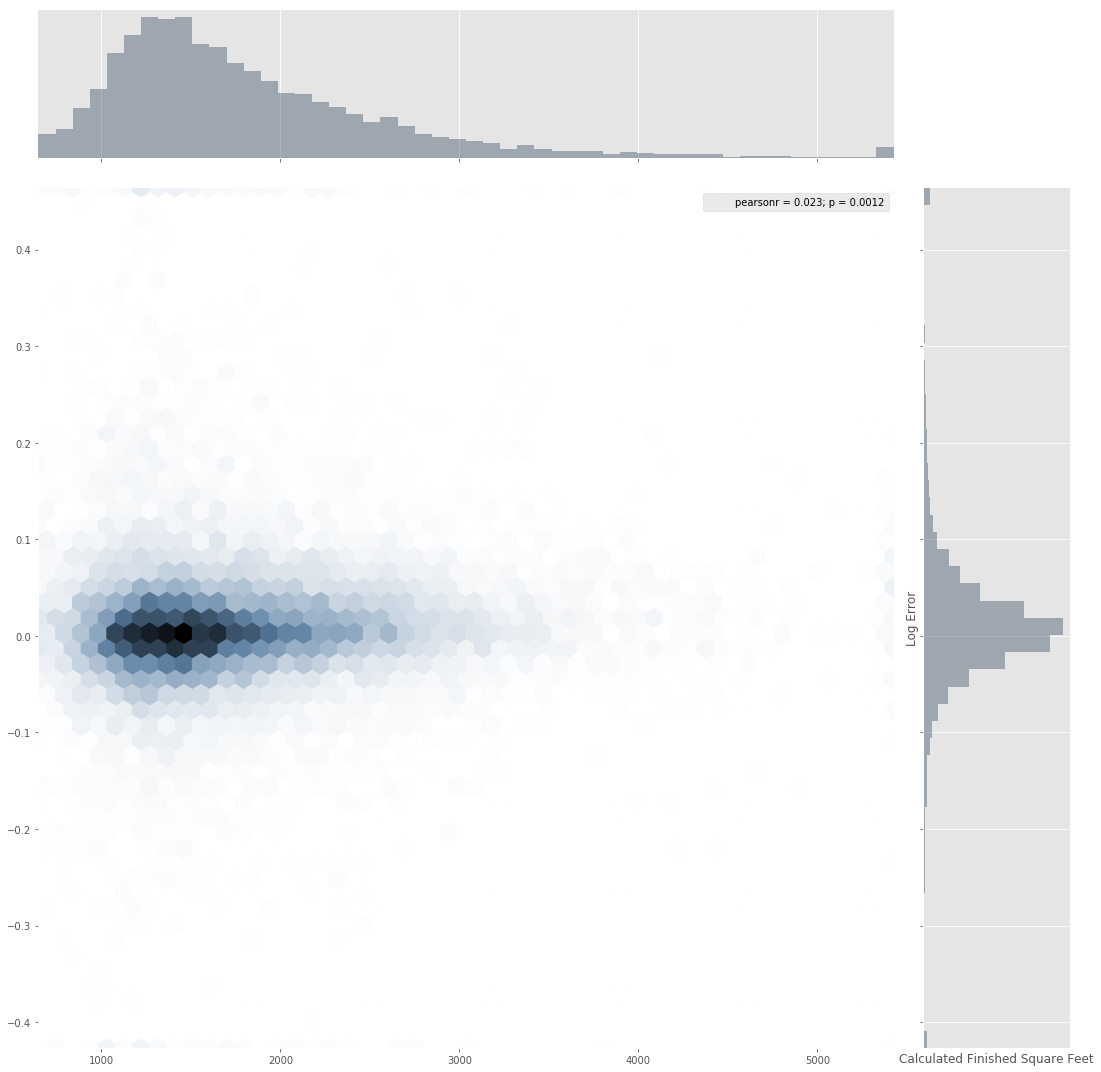

In [116]:
plt.figure(figsize=(8,8))
sn.jointplot(x=mergedFiltered.calculatedfinishedsquarefeet.values, y=mergedFiltered.logerror.values, size=15,kind="hex",color="#34495e")
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated Finished Square Feet', fontsize=12)
plt.show()

### Bedroom Count Vs Log Error

[Text(0,0.5,'Log Error'),
 Text(0.5,0,'Bedroom Count'),
 Text(0.5,1,'Bedroom Count Vs Log Error')]

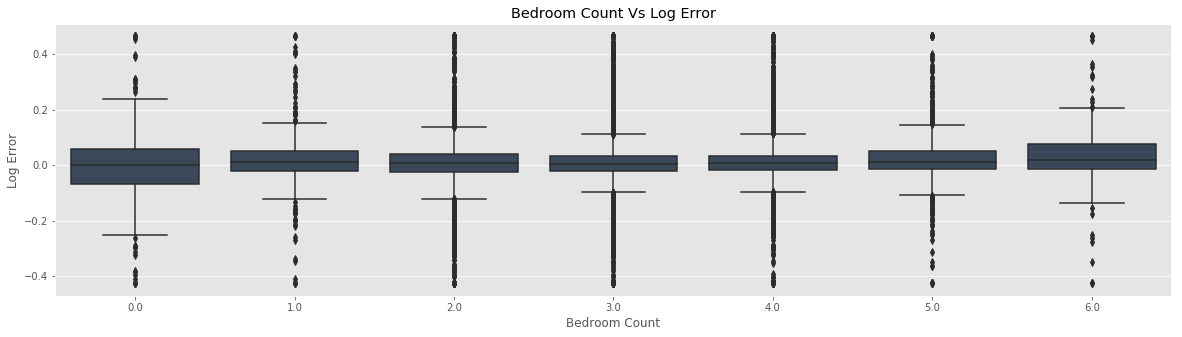

In [118]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.boxplot(x="bedroomcnt", y="logerror", data=mergedFiltered,ax=ax,color="#34495e")
ax.set(ylabel='Log Error',xlabel="Bedroom Count",title="Bedroom Count Vs Log Error")